In [3]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import sys
sys.path.append("src/")
import src.preprocessing.data_loading as data_loading
from src.preprocessing.data_loading import AA_REPRESENTATION
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow import keras
from functools import partial
import pandas as pd
from typing import List
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.colors import LogNorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm
import math


from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    seq_contains_mdm2_motif,
    seq_contains_12ca5_motif,
)
from utils.utils import seed_everything
from models.rnn import multi_channel_mse
import models.experiment as experiment
import models.rnn as rnn


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
model_types=[
    ("KNN", partial(KNeighborsRegressor, n_neighbors=35)),
    (
        "Random Forest",
        partial(RandomForestRegressor, n_estimators=200, max_depth=10),
    ),
    (
        "BiLSTM",
        partial(
            rnn.ThreeChannelRegressionRNN_gelu,
            depth=6,
            width=64,
            dropout=0.1,
            loss=multi_channel_mse,
        ),
    ),
]
values=[
    ("ER + FC", lambda x: x[1:]),
    ("ER", lambda x: [x[2]]),
    ("FC + P-val", lambda x: x[:2]),
    ("FC", lambda x: [x[1]]),
]
representations=[
    ("(One Hot)", [AA_REPRESENTATION.ONE_HOT]),
    (
        "(Physicochemical)",
        [
            AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
            AA_REPRESENTATION.PRO2VEC,
            AA_REPRESENTATION.RAA,
        ],
    ),
    (
        "(Physicochemical + One Hot)",
        [
            AA_REPRESENTATION.PRO2VEC,
            AA_REPRESENTATION.RAA,
            AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
            AA_REPRESENTATION.ONE_HOT,
        ],
    ),
]


In [5]:
def run_benchmark(
    args={
        "batch_size": 128,
        "weight_decay": 0.0,
        "learning_rate": 0.001,
        "num_epochs": 20,
    },
    model=partial(
        rnn.ThreeChannelRegressionRNN_gelu,
        depth=6,
        width=64,
        dropout=0.1,
        loss=multi_channel_mse,
    ),
    protein_of_interest="12ca5",
    other_protein="MDM2",
    aa_representations: List[AA_REPRESENTATION] = [
        AA_REPRESENTATION.PRO2VEC,
        AA_REPRESENTATION.RAA,
        AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
        AA_REPRESENTATION.ONE_HOT,
    ],
    index_lambda=("ER + FC", lambda x: x[1:]),
    raw_benchmark=False,
    cross_validation=True,
):
    top_k_size = 500 if protein_of_interest == "MDM2" else 1000
    seq_check = (
        seq_contains_mdm2_motif
        if protein_of_interest == "MDM2"
        else seq_contains_12ca5_motif
    )
    seed_everything(1)

    X, y_raw, peptides, FEATURE_LIST = data_loading.build_joint_dataset(
        er_datafile=f"{protein_of_interest}_merged_ER.csv",
        volcano_datafile="12ca5-MDM2-R3.csv",
        protein_of_interest=protein_of_interest,
        other_protein=other_protein,
        aa_representations=aa_representations,
    )
    y_raw = np.array([index_lambda[1](val) for val in y_raw])
    (
        X_holdout,
        X_train,
        y_holdout,
        y_train,
        peptides_holdout,
        peptides_train,
    ) = train_test_split(
        X,
        y_raw,
        peptides,
        test_size=0.8,
        shuffle=True,
        random_state=5,
    )
    # assert (pd.read_pickle("X_holdout.pkl") == X_holdout).all()
    # assert (pd.read_pickle("y_holdout.pkl") == y_holdout).all()

    def benchmark(y_pred, y_true, peptides):
        mdm2_ordering = [np.sum(pred) for pred in y_pred]
        result = plot_ratio_by_ranking(
            peptides=peptides,
            y_rankings=[(mdm2_ordering, "y_pred", "red")],
            title="",
            hit_rate_func=seq_check,
            peptide_dataset_size=top_k_size,
            plot=False,
            save_file=None,
        )
        return result

    if raw_benchmark:
        return benchmark(y_holdout, y_holdout, peptides_holdout)

    reps = ",".join([rep.name for rep in aa_representations])
    model_name = f"trained_models/comparison_models/poi({protein_of_interest})_dataset({reps}_index_lambda{index_lambda[0].replace('+', '').replace(' ', ',')}).h5"
    exp = experiment.Experiment()
    if cross_validation:
        results = exp.run_cross_validation_experiment(
            X_train,
            y_train,
            model,
            load_trained_model=os.path.exists(model_name + "8"),
            n_splits=10,
            model_save_name=model_name,
            normalize=True,
            batch_size=args["batch_size"],
            optimizer=partial(
                keras.optimizers.Adam,
                learning_rate=args["learning_rate"],
                weight_decay=args["weight_decay"],
            ),
            num_epochs=args["num_epochs"],
        )
        return [
            benchmark(
                exp.predict(result.trained_model, X_holdout, y_holdout)[0],
                y_holdout,
                peptides_holdout,
            )
            for result in results
        ]
    else:
        trained_model = exp.train(
            X_train,
            y_train,
            model,
            validation_split=0.0,
            load_trained_model=os.path.exists(model_name),
            model_save_name=model_name,
            batch_size=args["batch_size"],
            optimizer=partial(
                keras.optimizers.Adam,
                learning_rate=args["learning_rate"],
                weight_decay=args["weight_decay"],
            )(),
            num_epochs=args["num_epochs"],
        )
        y_pred, _ = exp.predict(trained_model, X_holdout, y_holdout)
        return [benchmark(y_pred, y_holdout, peptides_holdout)]


In [6]:
def create_matrix(
    protein_of_interest,
    other_protein,
    model_types,
    representations,
    values,
    save_file,
    cross_validation=False,
    num_splits=10,
):
    columns = []
    for model_type, _ in model_types:
        for rep_name, _ in representations:
            if cross_validation:
                for idx in range(num_splits):
                    columns.append(model_type + " " + rep_name + f":{idx}")
            else:
                columns.append(model_type + " " + rep_name)
    index = []
    for value, _ in values:
        index.append(value)

    save_file = f"{protein_of_interest}_model_comparisons.csv"
    if os.path.exists(save_file):
        result_df = pd.read_csv(save_file, index_col=0)
    else:
        result_df = pd.DataFrame(columns=columns, index=index, dtype=float)
        result_df.index.name = "Training Labels"

    # Run the model comparisons
    for rep_name, representation in tqdm(representations):
        for model_type, model in tqdm(model_types):
            for value, index_lambda in values:
                if (
                    cross_validation
                    and not math.isnan(
                        result_df.loc[value][model_type + " " + rep_name + ":9"]
                    )
                ) or (
                    not (cross_validation)
                    and not math.isnan(
                        result_df.loc[value][model_type + " " + rep_name]
                    )
                ):
                    continue
                result = run_benchmark(
                    model=model,
                    other_protein=other_protein,
                    protein_of_interest=protein_of_interest,
                    aa_representations=representation,
                    index_lambda=(value, index_lambda),
                    cross_validation=cross_validation,
                )
                if cross_validation:
                    for idx, res in enumerate(result):
                        result_df.loc[value][
                            model_type + " " + rep_name + f":{idx}"
                        ] = res
                else:
                    result_df.loc[value][model_type + " " + rep_name] = result[0]
                result_df.to_csv(save_file)
    return result_df


In [10]:
def visualize_benchmark(
    result_df,
    protein_of_interest,
    other_protein,
    model_types,
    representations,
    values,
    cross_validation=False,
    add_experimental_row=True,
):
    if add_experimental_row:
        result_df["Raw Experimental Values"] = [
            run_benchmark(
                protein_of_interest=protein_of_interest,
                other_protein=other_protein,
                index_lambda=tup,
                raw_benchmark=True,
            )
            for tup in values
        ]

    figure(figsize=(20, 10), dpi=300)
    if not cross_validation:
        sns.heatmap(
            result_df,
            annot=result_df,
            fmt=".2f",
            linewidths=0.5,
            cmap="Greens",
            annot_kws={"size": 25},
            square=True,
            norm=LogNorm(),
        )
    else:
        columns = []
        for model_type, _ in model_types:
            for rep_name, _ in representations:
                columns.append(model_type + " " + rep_name)
        index = []
        for value, _ in values:
            index.append(value)
        aggregated_result_df = pd.DataFrame(columns=columns, index=index, dtype=float)
        aggregated_result_df.index.name = "Training Labels"

        for row_idx, row in aggregated_result_df.iterrows():
            for col in columns:
                fold_results = [
                    result_df.loc[row.name][col + f":{fold_idx}"]
                    for fold_idx in range(10)
                ]
                median = np.var(fold_results)
                aggregated_result_df.loc[row.name][col] = median

        figure(figsize=(20, 10), dpi=300)
        result_df[result_df.columns].astype(float)

        sns.heatmap(
            aggregated_result_df,
            annot=aggregated_result_df,
            fmt=".2f",
            linewidths=0.5,
            cmap="Greens",
            annot_kws={"size": 25},
            square=True,
            norm=LogNorm(),
        )


  0%|                                                                                                      | 0/3 [00:00<?, ?it/s]


jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0                       

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.727575401488445
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0      

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.7318840579710145
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.7240501370936153
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)

 33%|███████████████████████████████▎                                                              | 1/3 [00:16<00:33, 16.90s/it]

0.7189580885233059
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.6676459067763416
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.7222875048962005
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.44672933803368586
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0    

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)

 67%|██████████████████████████████████████████████████████████████▋                               | 2/3 [02:22<01:20, 80.83s/it]

0.4694477085781434
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.6404230317273796
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.7052487269878575
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.600470035252644
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0      

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)

 33%|███████████████████████████████                                                              | 1/3 [02:39<05:19, 159.76s/it]

0.6623580101840971



  0%|                                                                                                      | 0/3 [00:00<?, ?it/s]

jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0                        

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.6760673717195457
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.699960830395613
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0      

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.6249510379945162
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)

 33%|███████████████████████████████▎                                                              | 1/3 [00:16<00:33, 16.51s/it]

0.63689776733255
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0       

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.7252252252252253
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.7197414806110458
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.5150802976889933
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)

 67%|██████████████████████████████████████████████████████████████                               | 2/3 [10:06<05:53, 353.98s/it]

0.4743439091265178
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.6987857422640031
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.7207207207207207
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.6384645515080297
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)

 67%|██████████████████████████████████████████████████████████████                               | 2/3 [13:03<07:12, 432.85s/it]

0.6102624363493929



  0%|                                                                                                      | 0/3 [00:00<?, ?it/s]

jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0                        

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.6762632197414806
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.699960830395613
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0      

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.6284763023893458
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)

 33%|███████████████████████████████▎                                                              | 1/3 [00:19<00:38, 19.04s/it]

0.6414022718370544
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.709361535448492
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0      

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.7289463376419898
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.5842146494320407
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)

 67%|██████████████████████████████████████████████████████████████                               | 2/3 [12:31<07:18, 438.52s/it]

0.5111633372502937
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.7311006658832746
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.6560908734821779
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.6580493537015276
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0     

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [25:52<00:00, 517.64s/it]

0.599882491186839


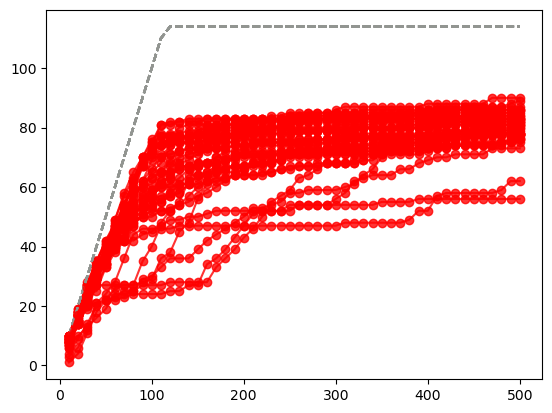

In [7]:
protein_of_interest = "MDM2"
other_protein = "12ca5"
save_file = f"{protein_of_interest}_model_comparisons.csv"

result_df = create_matrix(
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    model_types=model_types,
    representations=representations,
    values=values,
    save_file=save_file,
    cross_validation=False,
    num_splits=10,
)

In [8]:
result_df

,KNN (One Hot),KNN (Physicochemical),KNN (Physicochemical + One Hot),Random Forest (One Hot),Random Forest (Physicochemical),Random Forest (Physicochemical + One Hot),BiLSTM (One Hot),BiLSTM (Physicochemical),BiLSTM (Physicochemical + One Hot)
Training Labels,,,,,,,,,
ER + FC,0.727575,0.676067,0.676263,0.667646,0.725225,0.709362,0.640423,0.698786,0.731101
ER,0.731884,0.699961,0.699961,0.722288,0.719741,0.728946,0.705249,0.720721,0.656091
FC + P-val,0.724050,0.624951,0.628476,0.446729,0.515080,0.584215,0.600470,0.638465,0.658049
FC,0.718958,0.636898,0.641402,0.469448,0.474344,0.511163,0.662358,0.610262,0.599882


jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0                        

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.20877399138268704
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0    

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.23247160203681944
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0    

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.14120642381511947
jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0    

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


0.181942812377595


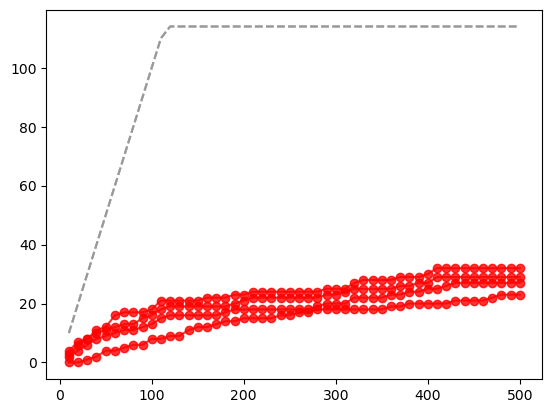

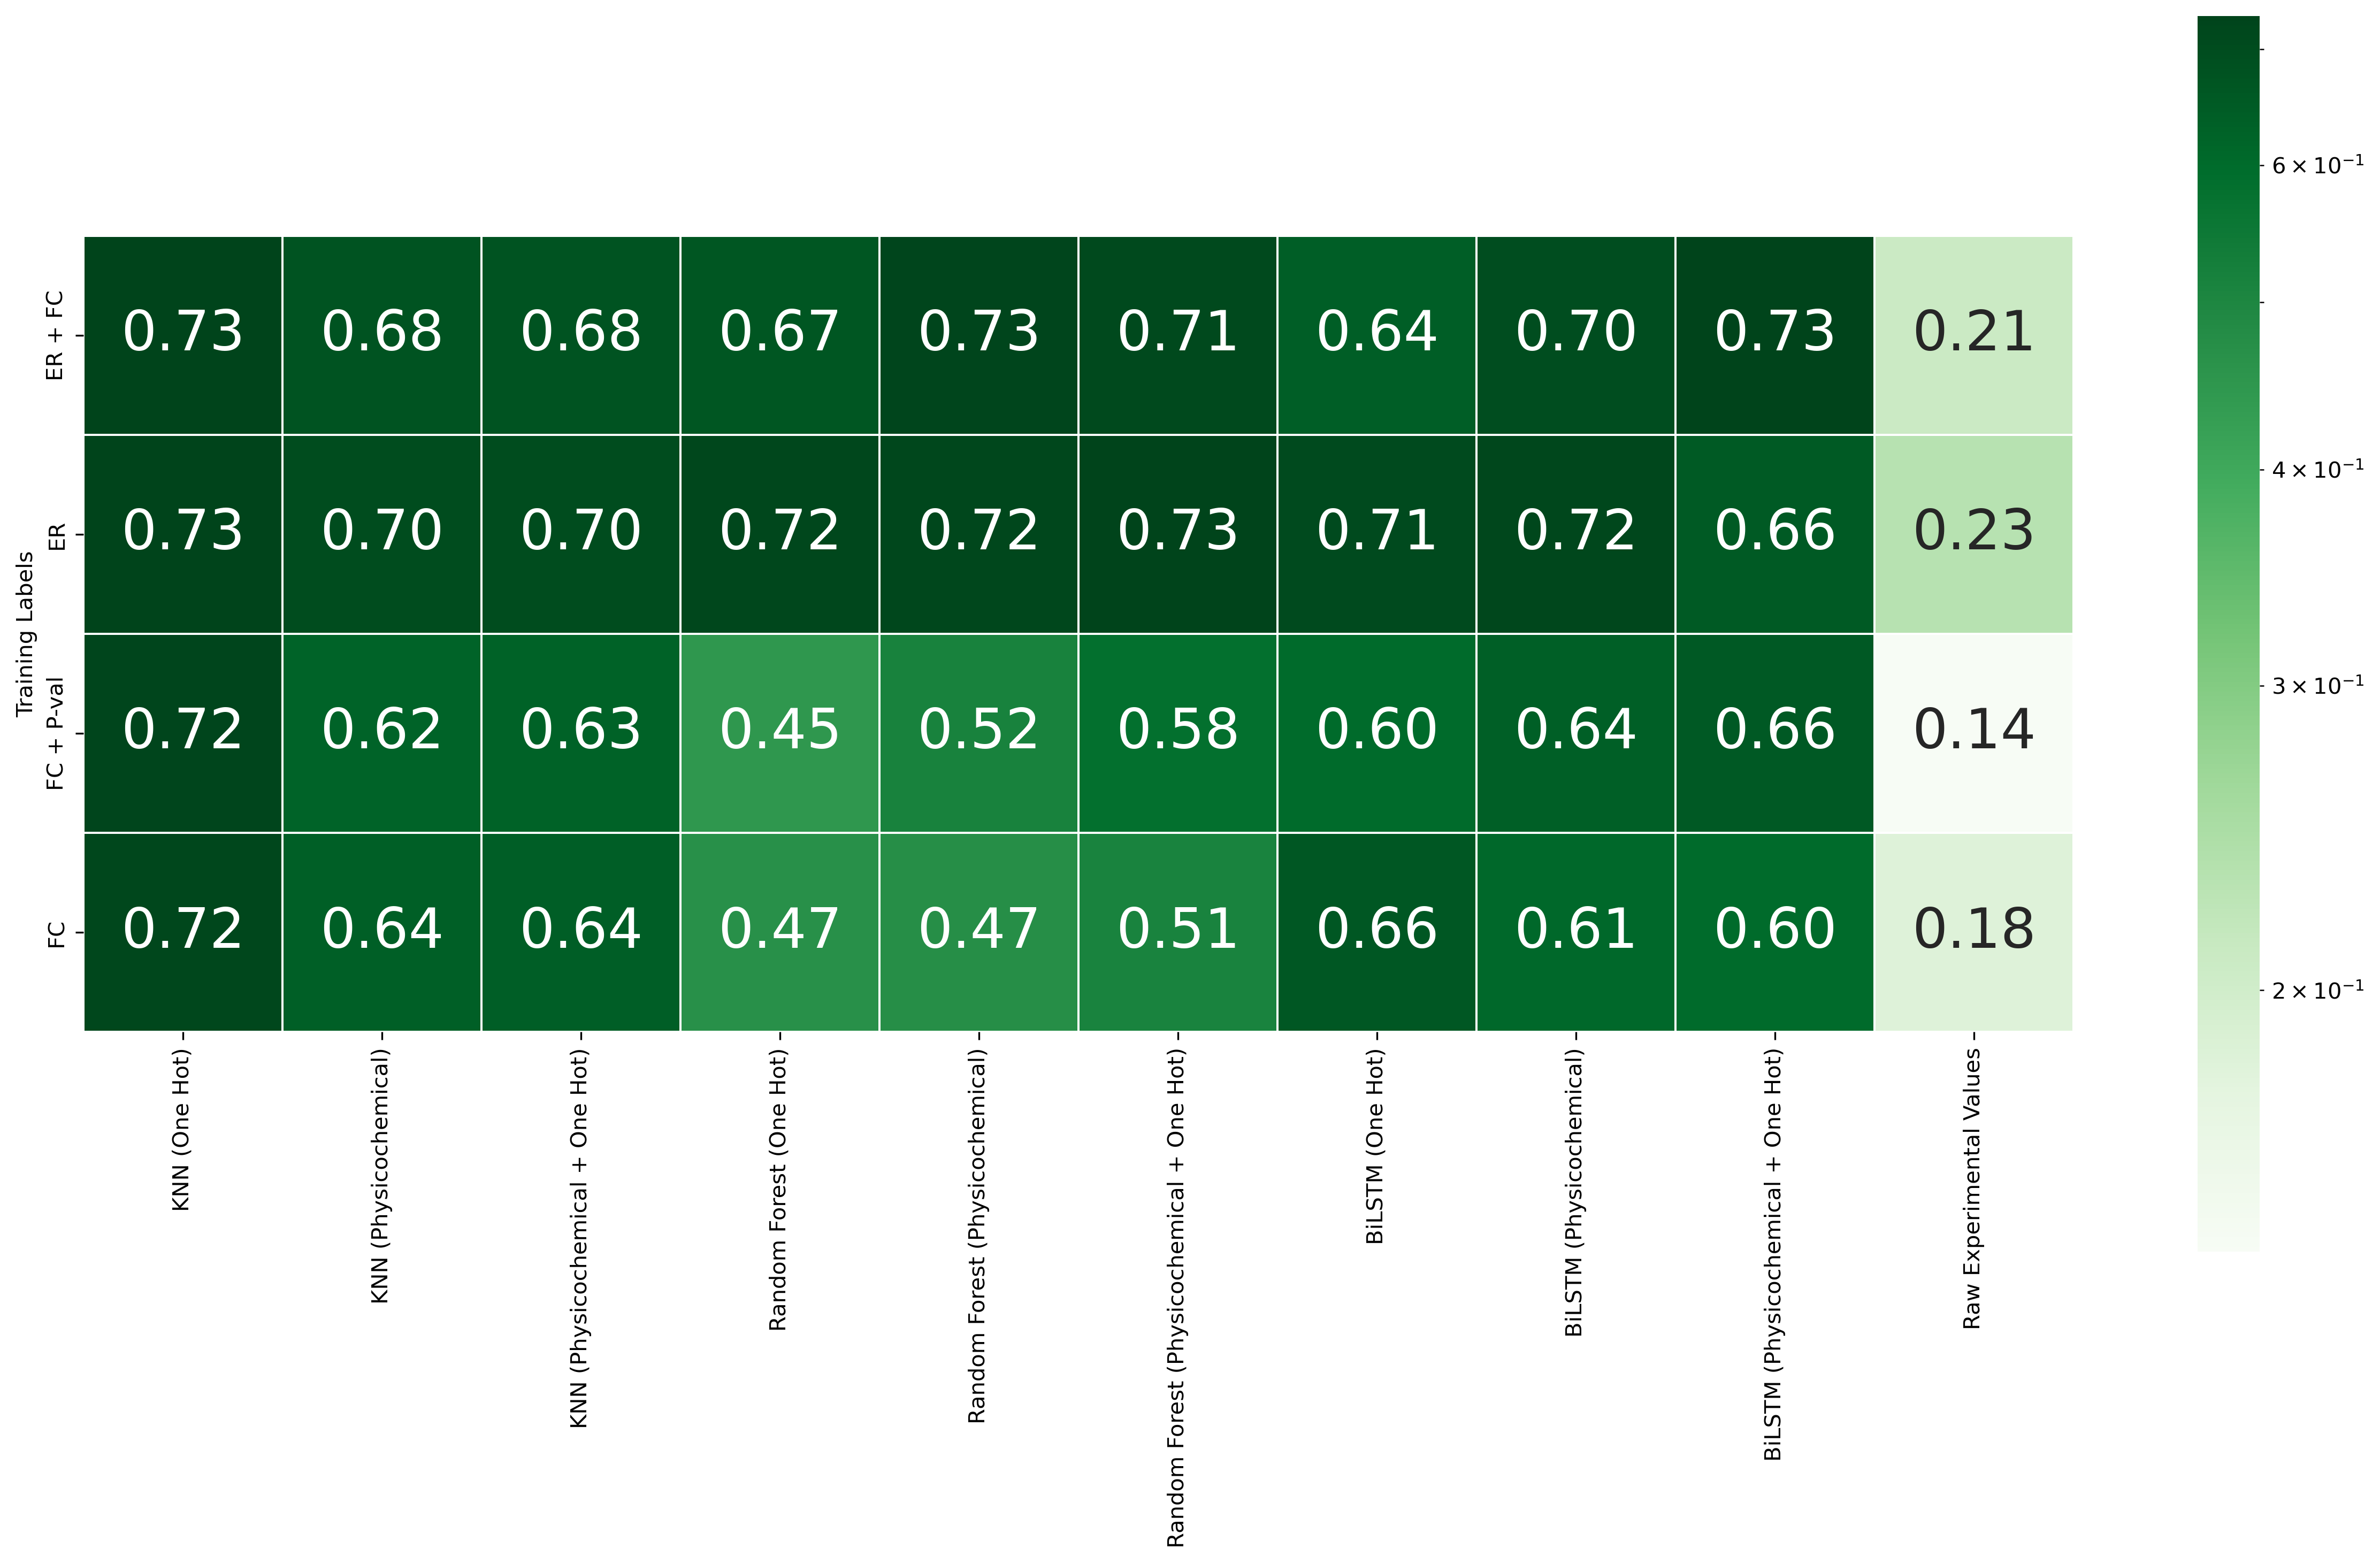

In [11]:
visualize_benchmark(
    result_df,
    protein_of_interest,
    other_protein,
    model_types,
    representations,
    values,
)

## Run for 12ca5

In [31]:
protein_of_interest = "12ca5"
other_protein = "MDM2"
save_file = f"{protein_of_interest}_model_comparisons.csv"

result_df = create_matrix(
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    model_types=model_types,
    representations=representations,
    values=values,
    save_file=save_file,
    cross_validation=False,
    num_splits=10,
)

100%|██████████| 3/3 [00:00<00:00, 164.06it/s]


In [32]:
result_df

,KNN (One Hot),KNN (Physicochemical),KNN (Physicochemical + One Hot),Random Forest (One Hot),Random Forest (Physicochemical),Random Forest (Physicochemical + One Hot),BiLSTM (One Hot),BiLSTM (Physicochemical),BiLSTM (Physicochemical + One Hot)
Training Labels,,,,,,,,,
ER + FC,0.784177,0.736491,0.736383,0.819483,0.825780,0.818837,0.866685,0.866039,0.875296
ER,0.659688,0.664532,0.664478,0.696609,0.697417,0.690743,0.649300,0.637029,0.679010
FC + P-val,0.857696,0.780248,0.780140,0.882239,0.888213,0.887513,0.841066,0.858235,0.865016
FC,0.853337,0.778633,0.778633,0.857858,0.884446,0.875727,0.841389,0.864209,0.854575


/home/yitongt/ml_phage/src/preprocessing/y_representation.py:63: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(
/home/yitongt/ml_phage/src/preprocessing/y_representation.py:63: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(
/home/yitongt/ml_phage/src/preprocessing/y_representation.py:63: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(
/home/yitongt/ml_phage/src/preprocessing/y_representation.py:63: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs wh

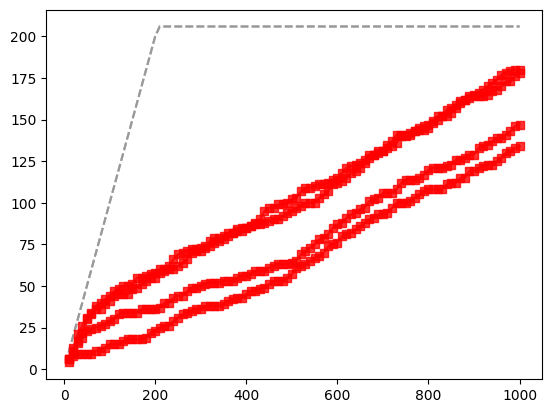

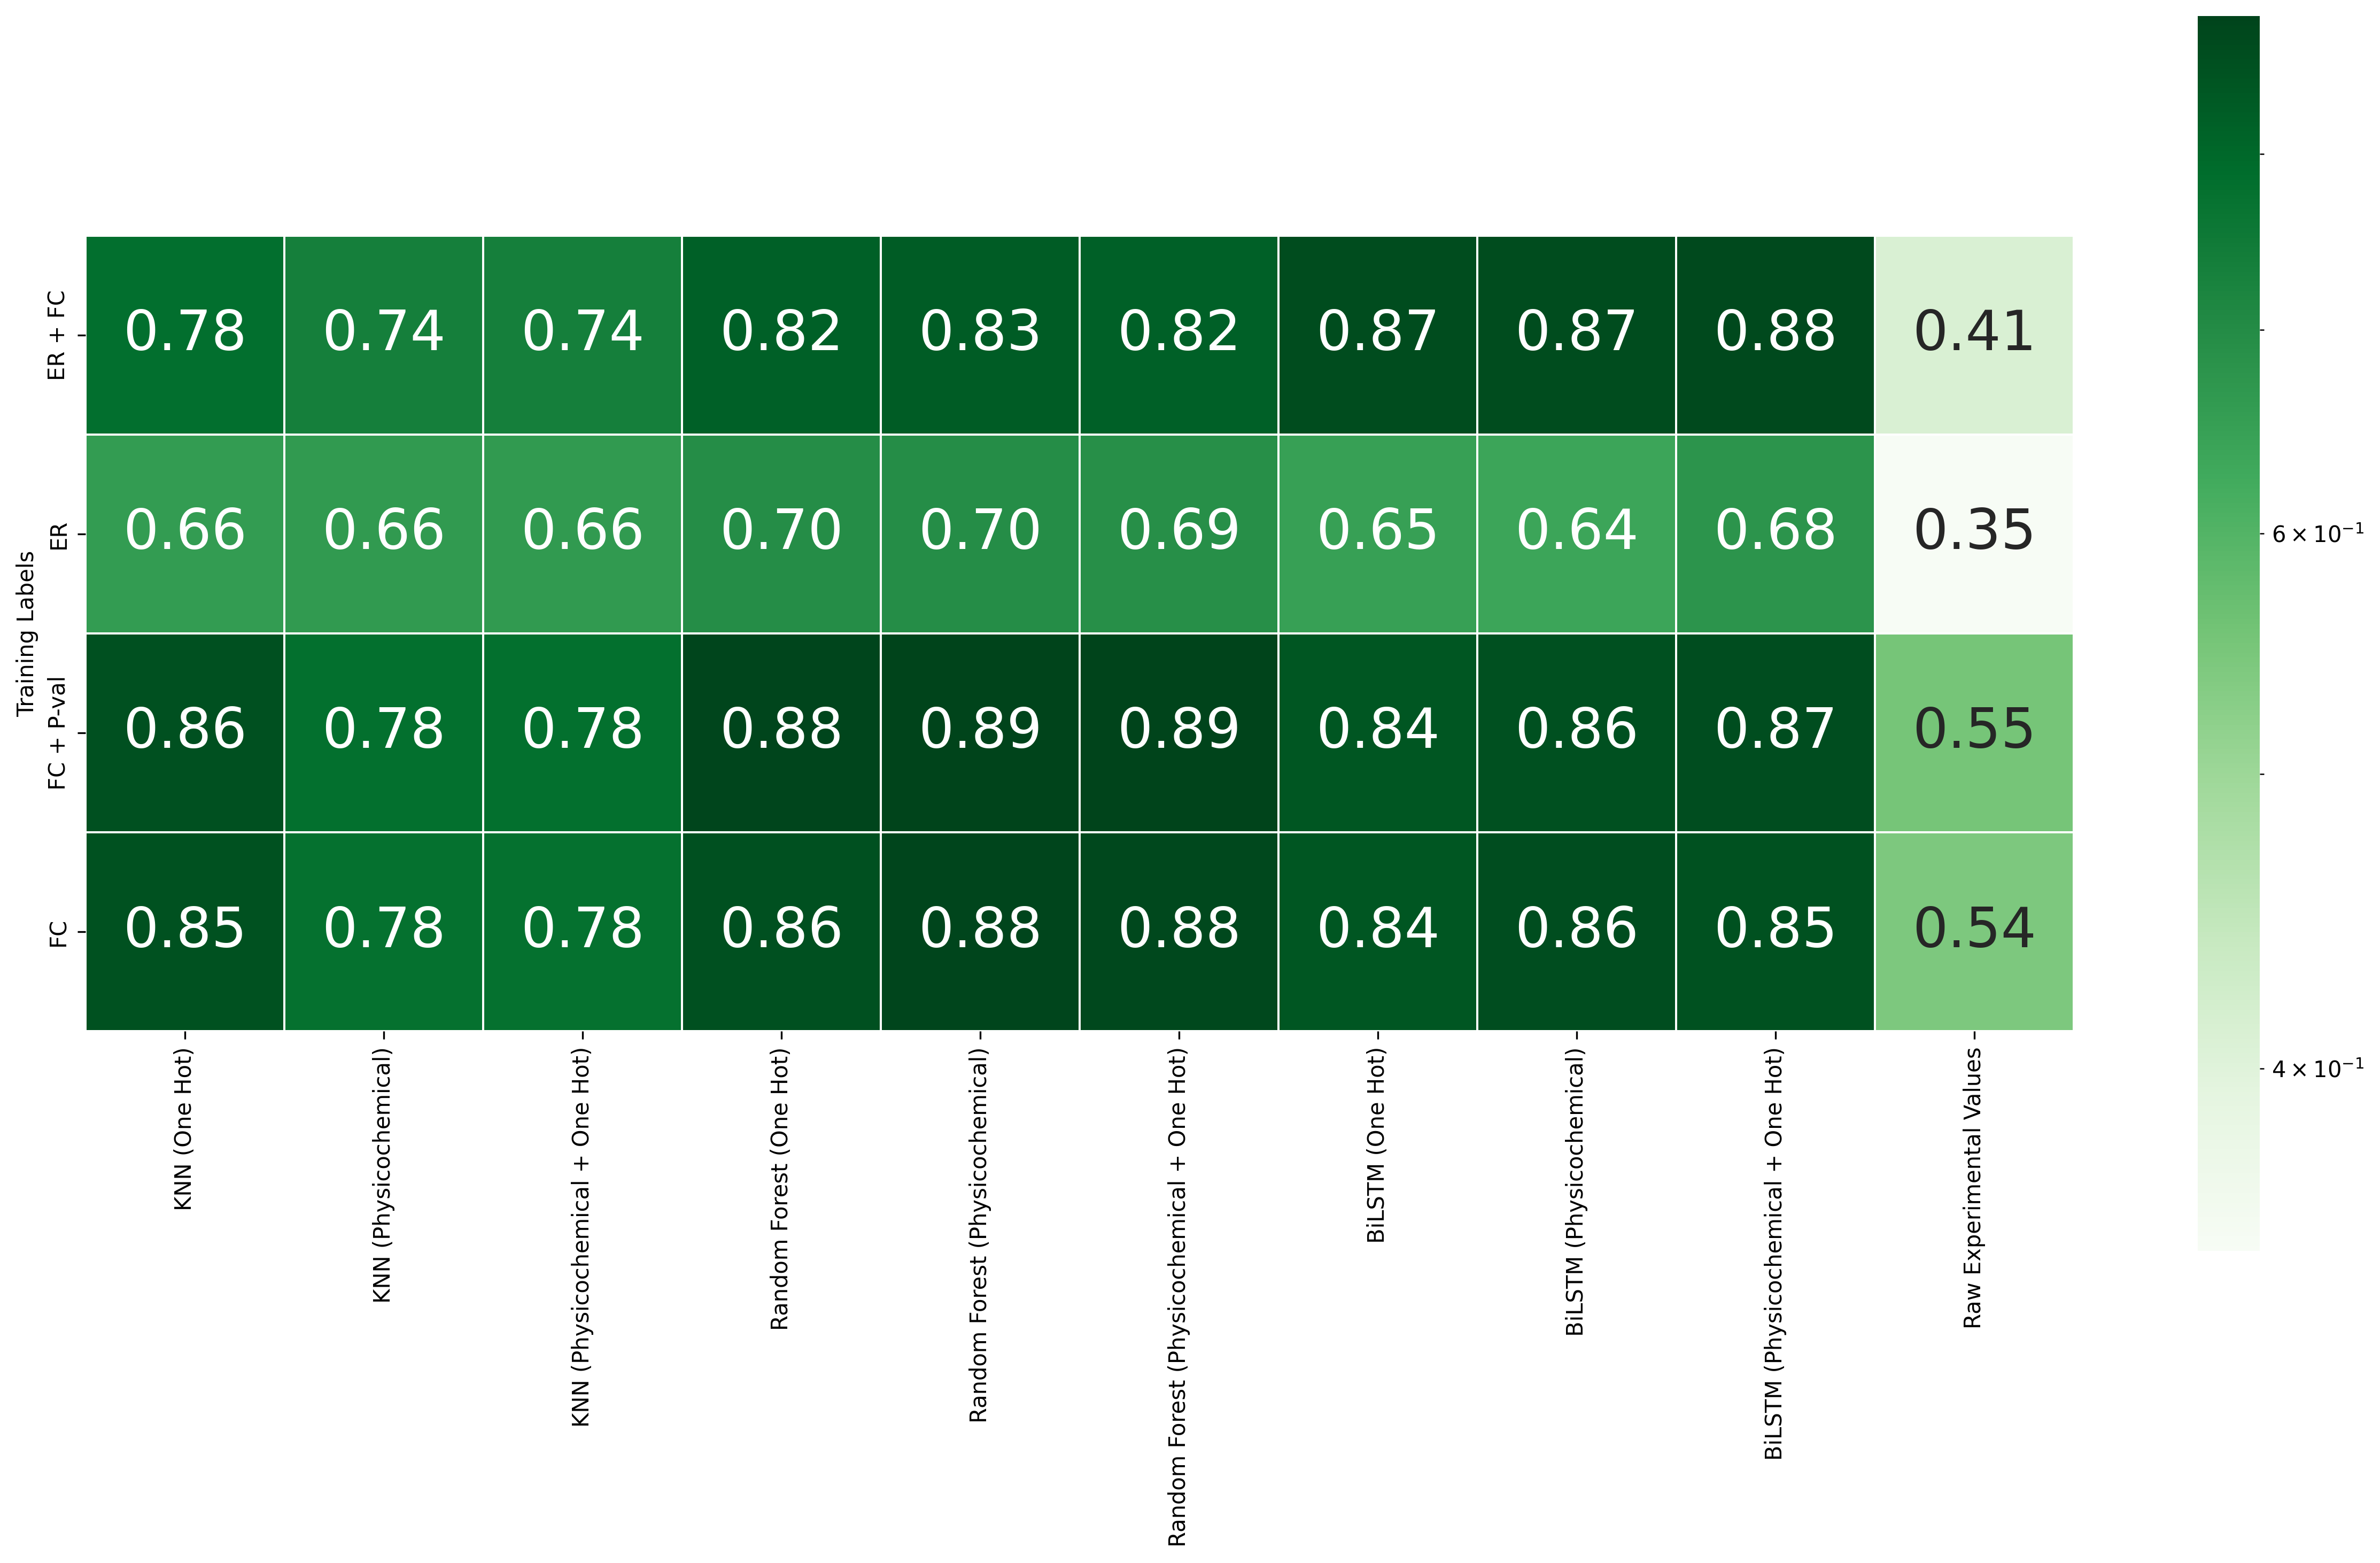

In [33]:
visualize_benchmark(
    result_df,
    protein_of_interest,
    other_protein,
    model_types,
    representations,
    values,
)